**Optimize Training and Compare Performance**

In [ ]:
'''
Optimized Training with
- Auto mixed precision AMP
- Cache Dataset for deterministic transforms
- Move data to GPU and cache then execute transforms on GPU
- Disable meta tracking intransforms to disable unnecessary computation
- Multi-threads Thread Data Loader faster than PyTorch DataLoader
- Analyzed training and tuning algorithm, use SGD optimizer and network parameters

With A100 GPU and target validation .95 it is 150x speedup compared to PyTorch
regular implementation. Each epoch is 50x faster than regular epoch
'''

In [ ]:
!pip install monai
!pip install monai-weekly
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning~=2.0
!python -c "import monai; print(monai.__version__)"
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os, shutil, tempfile, PIL, logging, sys, time, glob, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Adam, SGD
import monai
from monai.apps import download_and_extract, DecathlonDataset
from monai.data import (DataLoader, CacheDataset, Dataset, decollate_batch,
      ThreadDataLoader, pad_list_data_collate, set_track_meta)
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.layers import Norm, Act
from monai.config import print_config
from monai.transforms import (
    AsDiscrete, Compose, EnsureChannelFirstd, LoadImaged, Orientationd,
    RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd, CropForegroundd,
    EnsureTyped, FgBgToIndicesd)
from monai.utils import set_determinism
''' for profiling '''
import nvtx
from monai.utils.nvtx import Range
import contextlib
print_config()

In [11]:
''' seed/deterministic training for reproduceability '''
set_determinism(seed=0)
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!mkdir monai
os.environ['monai'] = '/content/monai'
dir = os.environ.get('monai')
rootdir = tempfile.mkdtemp() if dir is None else dir
rootdir

mkdir: cannot create directory ‘monai’: File exists


'/content/monai'

In [12]:
''' Training loop in PyTorch reuse code as in templates '''
def training_readiness(train_ds, val_ds):
    train_loader = DataLoader(
        train_ds, batch_size=2, shuffle=True, num_workers=8,)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

    device = torch.device("cuda:0")

    model = UNet(spatial_dims=3, in_channels=1, out_channels=2,
        channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
        num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(include_background=False, to_onehot_y=True,
        softmax=True, squared_pred=True, batch=True, smooth_nr=0.00001,
        smooth_dr=0.00001, lambda_dice=0.5, lambda_ce=0.5,)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.00004,)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])
    dice_metric = DiceMetric(
        include_background=True, reduction='mean', get_not_nans=False)

In [13]:
'''  Download and prepare the Dataset '''
resource = 'https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar'
md5 = '410d4a301da4e5b2f6f86ec3ddba524e'
compressed_file = os.path.join(rootdir, 'Task09_Spleen.tar')
datadir = os.path.join(rootdir, 'Task09_Spleen')
if not os.path.exists(datadir):
  download_and_extract(resource, compressed_file, rootdir, md5)

train_images = sorted(glob.glob(os.path.join(datadir, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(datadir, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [14]:
!mkdir outputs/
outdir = 'outputs/'
profiling = False
if profiling:
  max_epochs = 5
else:
  max_epochs = 300

def range_func(x, y):
  return Range(x)(y) if profiling else y

no_profiling = contextlib.nullcontext()

mkdir: cannot create directory ‘outputs/’: File exists


In [15]:
''' Prepare the transformations '''
def transformations(fast=False, device='cuda:0'):
    train_transforms = [
      range_func('LoadImage',
          LoadImaged(keys=['image', 'label'])),
      range_func('EnsureChannelFirst',
          EnsureChannelFirstd(keys=['image', 'label'])),
      range_func('Orientation',
          Orientationd(keys=['image', 'label'], axcodes='RAS')),
      range_func('Spacing',
          Spacingd(keys=['image', 'label'],
               pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest'))),
      range_func('ScaleIntensityRange',
          ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164,
                b_min=0.0, b_max=1.0, clip=True)),
      range_func('CropForeground',
          CropForegroundd(keys=['image', 'label'], source_key='image')),
      # precompute forground and background indexes,
      # cache them to accelerate training
      range_func(
          'Indexing',
          FgBgToIndicesd(
              keys = 'label',
              fg_postfix = '_fg',
              bg_postfix = '_bg',
              image_key = 'image'
          ),), ]
    if fast:
      # convert data to Tensor, move to GPU and cashe
      train_transforms.append(
        range_func('EnsureType',
          EnsureTyped(keys=['image', 'label'], device=device, track_meta=False)))

    train_transforms.append(
        range_func('RandCrop',
            RandCropByPosNegLabeld(
                keys=['image', 'label'], label_key='label',
                spatial_size=(96, 96, 96), pos=1, neg=1,
                num_samples=4, image_key='image', image_threshold=0,
                fg_indices_key="label_fg", bg_indices_key="label_bg",
                )))

    val_transforms = [
      LoadImaged(keys=['image', 'label']),
      EnsureChannelFirstd(keys=['image', 'label']),
      Orientationd(keys=['image', 'label'], axcodes='RAS'),
      Spacingd(keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
      ScaleIntensityRanged(keys=["image"], a_min=-57, a_max=164,
                b_min=0.0, b_max=1.0, clip=True),
      CropForegroundd(keys=["image", "label"], source_key='image')]

    if fast:
      # convert data to Tensor, move to GPU and cashe
      val_transforms.append(
          EnsureTyped(keys=['image', 'label'], device=device, track_meta=False))

    return Compose(train_transforms), Compose(val_transforms)

In [22]:
def training(fast=False):
    learning_rate = 2e-4
    val_interval = 5
    set_track_meta(True)

    device = torch.device("cuda:0")
    train_transforms, val_transforms = transformations(fast=fast, device=device)
    # set the Cache Dataset, Thread Data Loader DiceCE for acceleration
    if fast:
      train_ds = CacheDataset(data = train_files, transform = train_transforms,
                    cache_rate = 1.0, num_workers = 8, copy_cache = False)
      val_ds = CacheDataset(data = val_files, transform = val_transforms,
                    cache_rate = 1.0, num_workers = 5, copy_cache = False)

      train_loader = ThreadDataLoader(
          train_ds,  num_workers=0, batch_size=4, shuffle=True)
      val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

      model = UNet(
          spatial_dims=3, in_channels=1, out_channels=2,
          channels=(32, 64, 128, 256, 512), strides=(2, 2, 2, 2),
          num_res_units=2, norm=Norm.BATCH, kernel_size=3, up_kernel_size=3,
          act=Act.PRELU, dropout=.2, bias=True).to(device)
      loss_function = DiceCELoss(
          include_background=False, to_onehot_y=True, softmax=True,
          squared_pred=True, batch=True, smooth_nr=0.00001, smooth_dr=0.00001,
          lambda_dice=0.5, lambda_ce=0.5,)
      optimizer = torch.optim.SGD(model.parameters(),
          lr=learning_rate*1000, momentum=0.9, weight_decay=0.00004)
      scaler = torch.amp.GradScaler()
      # avoid computation of meta information
      set_track_meta(False)
    else:
      train_ds = Dataset(data=train_files, transform = train_transforms)
      val_ds = Dataset(data=val_files, transform = val_transforms)
      train_loader = DataLoader(
          train_ds, batch_size=2, shuffle=True, num_workers=8,
          collate_fn=pad_list_data_collate, )
      val_loader = DataLoader(val_ds, batch_size=1, num_workers=4,
          collate_fn=pad_list_data_collate)
      loss_function = DiceLoss(to_onehot_y=True, softmax=True)
      model = UNet(
          spatial_dims=3, in_channels=1, out_channels=2,
          channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
          num_res_units=2, norm=Norm.BATCH).to(device)
      optimizer = Adam(model.parameters(), learning_rate)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])
    dice_metric = DiceMetric(
        include_background=True, reduction='mean', get_not_nans=False)

    best_metric = -1
    best_metric_epoch = -1
    best_metrics_epochs_and_time = [ [], [], []]
    epoch_loss_values, metric_values, epoch_times = [], [], []
    total_start = time.time()


    for epoch in range(max_epochs):
      epoch_start = time.time()
      with nvtx.annotate('epoch', color='red') if profiling else no_profiling:
          model.train()
          epoch_loss = 0
          train_iterator = iter(train_loader)
          for step in range(1, len(train_loader) +1):
              step_start = time.time()
              # optional to choose profiling train dataload
              with nvtx.annotate('dataload', color='red') \
                      if profiling else no_profiling:
                batch_data = next(train_iterator)
                inputs, labels = (
                    batch_data['image'].to(device),
                    batch_data['label'].to(device)
                )
              optimizer.zero_grad()
              # set AMP for Training
              if fast:
                # profiling forward
                 with nvtx.annotate('forward', color='blue') \
                        if profiling else no_profiling:
                    with torch.cuda.amp.autocast():
                      outputs = model(inputs)
                      loss = loss_function(outputs, labels)
                # profiling backward
                 with nvtx.annotate('backward', color='blue') \
                        if profiling else no_profiling:
                    scaler.scale(loss).backward()
                # profiling update
                 with nvtx.annotate('update', color='blue') \
                        if profiling else no_profiling:
                    scaler.step(optimizer)
                    scaler.update()
              else:
                # profiling forward
                 with nvtx.annotate('forward', color='yellow') \
                        if profiling else no_profiling:
                    with torch.cuda.amp.autocast():
                      outputs = model(inputs)
                      loss = loss_function(outputs, labels)
                # profiling backward
                 with nvtx.annotate('backward', color='yellow') \
                        if profiling else no_profiling:
                    loss.backward()
                # profiling update
                 with nvtx.annotate('update', color='yellow') \
                        if profiling else no_profiling:
                    optimizer.step()

              epoch_loss += loss.item()
              epoch_len = math.ceil(len(train_ds) / train_loader.batch_size)

      epoch_loss /= step
      epoch_loss_values.append(epoch_loss)
      print(f'epoch {epoch +1} average loss: {epoch_loss:.4f}')

      if (epoch +1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
          val_iter = iter(val_loader)
          for _ in range(len(val_loader)):
            with nvtx.annotate('dataload', color='red') \
                          if profiling else no_profiling:
              val_data = next(val_iter)
              val_inputs, val_labels = (
                  val_data['image'].to(device),
                  val_data['label'].to(device))

            roi_size = (160, 160, 160)
            sw_batch_size = 4

            with nvtx.annotate('sliding window reference', color='blue') \
                              if profiling else no_profiling:
              if fast:
                with torch.cuda.amp.autocast():
                  val_outputs = sliding_window_inference(
                      val_inputs, roi_size, sw_batch_size, model)
              else:
                val_outputs = sliding_window_inference(
                      val_inputs, roi_size, sw_batch_size, model)

            with nvtx.annotate('decollate batch', color='blue') \
                              if profiling else no_profiling:
              val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
              val_labels = [post_pred(i) for i in decollate_batch(val_labels)]

            with nvtx.annotate('compute metric', color='blue') \
                              if profiling else no_profiling:
              dice_metric(y_pred=val_outputs, y = val_labels)

            del  val_data, val_outputs, val_labels

          metric = dice_metric.aggregate().item()
          dice_metric.reset()
          metric_values.append(metric)
          if metric > best_metric:
            best_metric = metric
            best_metric_epoch = epoch +1
            best_metrics_epochs_and_time[0].append(best_metric)
            best_metrics_epochs_and_time[1].append(best_metric_epoch)
            best_metrics_epochs_and_time[2].append(time.time() -total_start)
            torch.save(model.state_dict(), os.path.join(rootdir, 'best_metric_model.pt'))

      #print(f'time consuming of epoch {epoch +1} is {(time.time() - epoch.start):.4f}')
      epoch_times.append(time.time() - epoch_start)


    total_time = time.time() - total_start
    return (
        max_epochs, epoch_loss_values, metric_values, epoch_times,
        best_metrics_epochs_and_time, total_time
    )

In [ ]:
''' Run Regular PyTorch Training '''
set_determinism(seed=0)
regular_start = time.time()

(epoch_num, epoch_loss_values, metric_values, epoch_times, best,
    train_time) = training(fast=False)

In [23]:
''' Run Optimized PyTorch Training '''
set_determinism(seed=0)
opt_regular_start = time.time()

(opt_epoch_num, opt_epoch_loss_values, opt_metric_values, opt_epoch_times, opt_best,
    opt_train_time) = training(fast=True)

epoch 296 average loss: 0.0176
epoch 297 average loss: 0.0175
epoch 298 average loss: 0.0170
epoch 299 average loss: 0.0174
epoch 300 average loss: 0.0180


**Training loss and validation metrics**

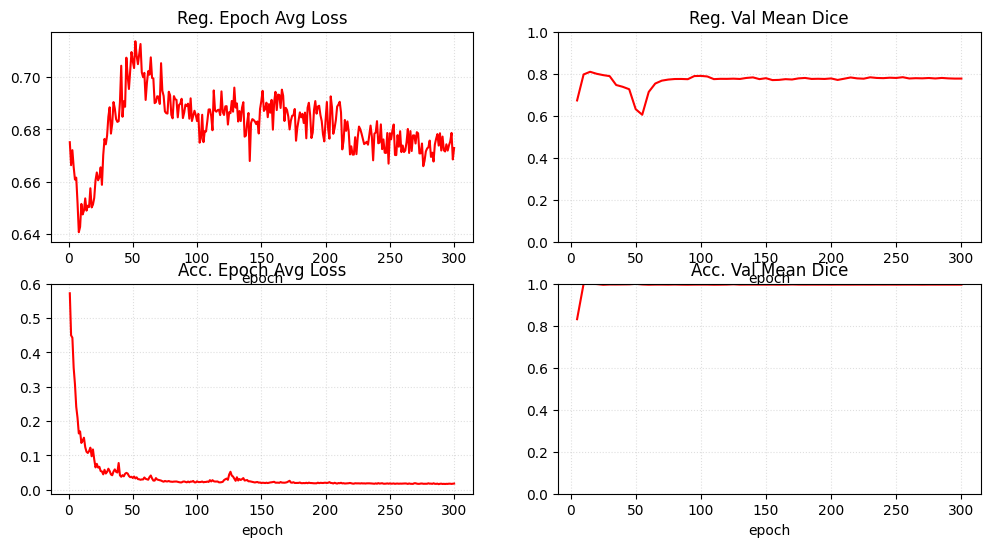

In [32]:
if not profiling:
    plt.figure('train', (12, 6))

    plt.subplot(2, 2, 1)
    plt.title('Reg. Epoch Avg Loss')
    x = [i+1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel('epoch')
    plt.grid(alpha=.4, linestyle=':')
    plt.plot(x, y, color='red')

    plt.subplot(2, 2, 2)
    plt.title('Reg. Val Mean Dice')
    x = [(i+1)*5 for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.grid(alpha=.4, linestyle=':')
    plt.plot(x, y, color='red')

    plt.subplot(2, 2, 3)
    plt.title('Acc. Epoch Avg Loss')
    x = [i+1 for i in range(len(opt_epoch_loss_values))]
    y = opt_epoch_loss_values
    plt.xlabel('epoch')
    plt.grid(alpha=.4, linestyle=':')
    plt.plot(x, y, color='red')

    plt.subplot(2, 2, 4)
    plt.title('Acc. Val Mean Dice')
    x = [(i + 1)*5 for i in range(len(opt_metric_values))]
    y = opt_metric_values
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.grid(alpha=.4, linestyle=':')
    plt.plot(x, y, color='red')

**Total time and every epoch time**

In [33]:
total_time = train_time + regular_start
opt_total_time = opt_train_time + regular_start

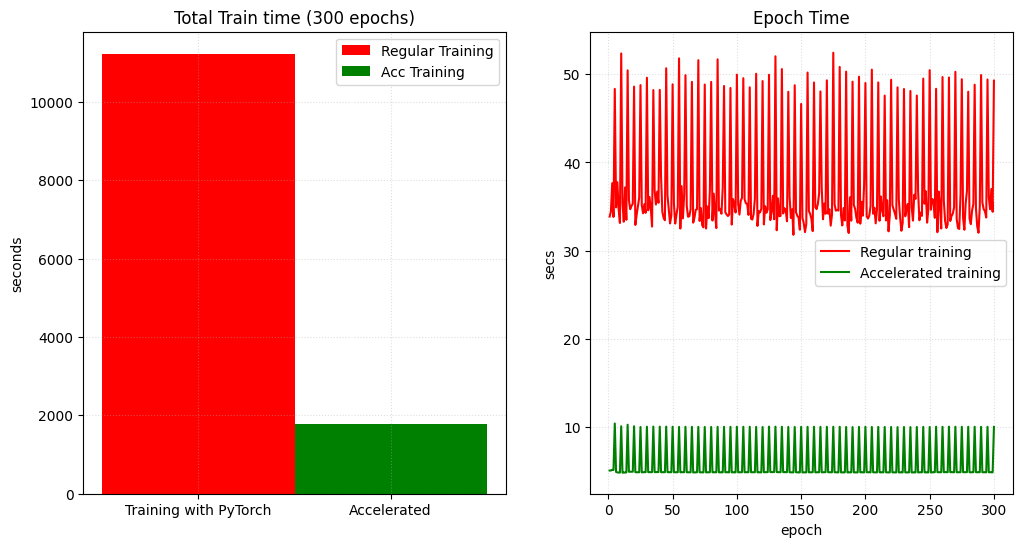

In [36]:
if not profiling:
    plt.figure('train', (12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Total Train time (300 epochs)')
    plt.bar('Training with PyTorch', train_time, 1, label='Regular Training', color='red')
    plt.bar('Accelerated', opt_train_time, 1, label='Acc Training', color='green')
    plt.ylabel('seconds')
    plt.grid(alpha=.4, linestyle=':')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Epoch Time')
    x = [i +1 for i in range(len(epoch_times))]
    plt.xlabel('epoch')
    plt.ylabel('secs')
    plt.plot(x, epoch_times, label='Regular training', color='red')
    plt.plot(x, opt_epoch_times, label='Accelerated training', color='green')
    plt.grid(alpha=.4, linestyle=':')
    plt.legend(loc='best')

    plt.show()